In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [3]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [ ]:
crypto = ['ADA', 'ATOM','BCH','BNB','DOGE','ETH' ,'LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ', 'BTC']
etfs = ['BTC']

df = pd.read_csv('/Users/imath/Desktop/TMBA/main_datafram_1h.csv')
df = df.set_index('timestamp')

In [ ]:
bbh =  ['MRNA', 'AMGN', 'IQV', 'ICLR', 'VRTX', 'GILD', 'REGN', 'ILMN', 'CRL', 'SGEN', 'BIIB', 
        'TECH', 'BNTX', 'BGNE', 'EXAS', 'ALNY', 'NVAX', 'QGEN', 'GH', 'NTRA', 'BMRN', 'INCY', 
        'TXG', 'NTLA', 'CRSP']

stocks = bbh
etfs = ['BBH', 'IDNA', 'SPY']

spy = pd.read_csv('spy_ohlc.csv', index_col=0)
prices = pd.read_csv('bbh_idna.csv', index_col=0)
prices['SPY'] = spy['5. adjusted close']
prices = prices[stocks+etfs]

returns = prices.pct_change().dropna()
returns

In [ ]:
s_scores = pd.DataFrame(index=returns.iloc[59:].index, columns=stocks)
betas = pd.DataFrame(index=returns.iloc[59:].index, columns=stocks)

for t in returns.index[59:]:
    # prepare data
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-60:]
    tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
    
    ou_parameters = pd.DataFrame(index=stocks, columns=['a', 'b', 'Var(zeta)', 'kappa', 'm', 
                                                      'sigma', 'sigma_eq'])
    
    for stock in stocks:
        X = tmp_ret[etfs].values
        y = tmp_ret[stock].values
        model1 = Ridge().fit(X,y) 
        betas.loc[t,stock] = model1.coef_
        epsilon = y - model1.predict(X)

        # second regression
        Xk = epsilon.cumsum()
        X = Xk[:-1].reshape(-1,1)
        y = Xk[1:]
        model2 = LinearRegression().fit(X,y)
        a = model2.intercept_
        b = model2.coef_
        zeta = y - model2.predict(X)

        # OU parameters
        kappa = -np.log(b)*252
        m = a/(1-b)
        sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
        sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

        # if the speed of mean reversion is high enough, save the calculated parameters
        if kappa>252/30:
            ou_parameters.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    ou_parameters.dropna(axis=0, inplace=True)

    # calculate s-score
    ou_parameters['m_bar'] = (ou_parameters['a']/(1 - ou_parameters['b']) - 
                              ou_parameters['a'].mean()/(1-ou_parameters['b'].mean()))
    ou_parameters['s'] = -ou_parameters['m_bar'] / ou_parameters['sigma_eq']
    s_scores.loc[t] = ou_parameters['s']
    
s_scores.fillna(0, inplace=True)
    
# calculate positions
algo_pos = pd.DataFrame(index=s_scores.index[1:], columns=stocks)

for s in stocks:
    positions = pd.DataFrame(index=s_scores.index, columns=[s])
    pos = 0
    for t in s_scores.index:
        score = s_scores.loc[t][s]
        if score>1.25:
            positions.loc[t][s] = -1 # open short
            pos = -1
        elif score<-1.25:
            positions.loc[t][s] = 1 # open long
            pos = 1
        elif score<0.75 and pos==-1: 
            positions.loc[t][s] = 0 # close short
            pos = 0
        elif score>-0.5 and pos==1:
            positions.loc[t][s] = 0 # close long
            pos = 0
        else:
            positions.loc[t][s] = pos # carry forward current position

    algo_pos[s] = positions
    
# calculate weights (allocate equal amount of capital to long\short positions)
algo_weights = pd.DataFrame(index=algo_pos.index, columns=stocks)

for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) # equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) # equal weights among short positions
    algo_weights.loc[t] = tmp
    
# calculate positions in ETFs
algo_weights[etfs] = -np.stack((betas.iloc[1:,:]*algo_weights).sum(axis=1).values)

# calculate returns
ret = (returns.iloc[59:] * algo_weights.shift()).sum(axis=1) / (abs(algo_weights.shift()).sum(axis=1)/2)
cumret = np.nancumprod(ret+1)

# calculate returns of SPY and BBH for comparison
spy = pd.read_csv('spy_ohlc.csv', index_col=0)
spy_returns = spy['5. adjusted close'].pct_change()
spy_returns = spy_returns.loc[returns.index]
spy_cumret = np.nancumprod(spy_returns.iloc[59:]+1)
bbh_cumret = np.nancumprod(returns.iloc[59:]['BBH']+1)

plt.figure(figsize=(18,6))
plt.plot(cumret, label='Algo')
plt.plot(bbh_cumret/bbh_cumret[0], label='BBH')
plt.plot(spy_cumret/spy_cumret[0], label='SPY')
plt.legend()

In [ ]:
# fraction of returns to pay transaction costs for
tc_frac = abs(algo_pos.shift().diff()).sum(axis=1)/abs(algo_pos.shift()).sum(axis=1)
# assume two-way transaction cost of 0.1%
ret_tc = ret - 0.0005*2*tc_frac # multiply by 2 since we use 2x capital
cumret_tc = np.nancumprod(1+ret_tc)

In [ ]:
results = pd.DataFrame(index=['SPY', 'BBH', 'Algo', 'Algo_with_tc'], columns=['total_return', 'apr', 'Sharpe', 
                                                                       'maxDD', 'maxDDD'])
results.loc['SPY'] = calculate_metrics(spy_cumret)
results.loc['BBH'] = calculate_metrics(bbh_cumret)
results.loc['Algo'] = calculate_metrics(cumret)
results.loc['Algo_with_tc'] = calculate_metrics(cumret_tc)
results

In [ ]:
stocks = bbh
etfs = ['BBH']

prices = pd.read_csv('bbh_idna.csv', index_col=0)
prices = prices[stocks+etfs]
returns = prices.pct_change().dropna()
returns

In [ ]:
evals, evecs = np.linalg.eig(returns[stocks].corr())

In [ ]:
np.sort(evals)[::-1]

In [ ]:
# plot eigenvalues measured as percentage of explained variance
plt.figure(figsize=(18,6))
plt.bar(np.arange(1,26), height=(np.sort(evals)[::-1])/evals.sum())
plt.xlim(0.5,25.5)
plt.ylim(0,0.4)

In [ ]:
# calculate returns of the principal eigenportfolio
weights = evecs[:,0]/returns[stocks].std()
weights = weights/weights.sum()
ret_eig = np.cumprod((weights*returns[stocks]).sum(axis=1)+1)
ret_ind = np.cumprod(returns[etfs]+1) # returns of the market (ETF)

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(ret_eig, label='Eigenportfolio')
plt.plot(ret_ind, label='BBH')
plt.legend()

In [ ]:
# evolution of percentage of variance explained by first PC
explained_variance = []

for t in returns.iloc[59:].index:
    tmp_ret = returns[stocks].loc[:t]
    tmp_ret = tmp_ret.iloc[-60:]
    evals = np.linalg.eig(tmp_ret.corr())[0]
    evals = np.sort(evals)[::-1]
    explained_variance.append(evals[0]/evals.sum())
    
plt.figure(figsize=(18,6))
plt.plot(explained_variance, label='Fraction of variance explained by 1st PC')
plt.legend()

In [ ]:
# evolution of percentage of variance explained by top 5 PCs
explained_variance = []

for t in returns.iloc[59:].index:
    tmp_ret = returns[stocks].loc[:t]
    tmp_ret = tmp_ret.iloc[-60:]
    evals = np.linalg.eig(tmp_ret.corr())[0]
    evals = np.sort(evals)[::-1]
    explained_variance.append(evals[:5].sum()/evals.sum())
    
plt.figure(figsize=(18,6))
plt.plot(explained_variance, label='Fraction of variance explained by top 5 PCs')
plt.legend()

In [ ]:
['ADA',
 'ATOM',
 'BCH',
 'BNB',
 'BTC',
 'CRO',
 'DOGE',
 'ETH',
 'LINK',
 'LTC',
 'TRX',
 'VET',
 'XLM',
 'XMR',
 'XRP',
 'XTZ']

## 1D OU

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [227]:
df = pd.read_csv('/Users/imath/Desktop/TMBA/配對交易/pair trade data/df/main_datafram_1d.csv')
df = df.set_index('timestamp')

crypto = ['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ']
etfs = ['BTC']

prices = df[['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ','BTC']]
prices['BTC_'] = prices['BTC']
prices.sort_index()
prices = prices.loc['2021-01-01':'2022-12-01']
prices

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/2158897192.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['BTC_'] = prices['BTC']


,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ,BTC,BTC_
timestamp,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0.17509,5.861,341.83,37.7762,0.005680,728.91,11.8477,126.24,0.02685,0.019052,0.13207,135.81,0.23746,2.0075,29331.69,29331.69
2021-01-02 00:00:00+00:00,0.17742,5.420,354.55,38.2331,0.010526,774.56,12.2215,136.96,0.02721,0.019993,0.12751,143.52,0.22064,1.9992,32178.33,32178.33
2021-01-03 00:00:00+00:00,0.20615,5.829,423.61,41.2575,0.009821,978.28,13.6814,161.24,0.02949,0.026226,0.13653,138.26,0.22540,2.1345,33000.05,33000.05
2021-01-04 00:00:00+00:00,0.22528,6.044,405.49,41.1333,0.009761,1041.43,13.5935,155.34,0.03095,0.024598,0.16404,133.79,0.23565,2.3284,31988.71,31988.71
2021-01-05 00:00:00+00:00,0.25873,6.196,418.09,41.8219,0.009970,1099.56,14.5162,158.43,0.02852,0.027964,0.19291,136.00,0.22573,2.3770,33949.53,33949.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-26 00:00:00+00:00,0.31380,10.111,112.50,311.4000,0.088930,1205.60,7.1560,76.47,0.05279,0.018900,0.08810,138.80,0.39600,0.9880,16458.57,16458.57
2022-11-27 00:00:00+00:00,0.31260,9.925,111.20,307.6000,0.098680,1193.88,6.9020,74.92,0.05327,0.018780,0.09020,136.50,0.39620,0.9880,16428.78,16428.78
2022-11-28 00:00:00+00:00,0.30660,9.862,110.00,293.5000,0.095130,1167.77,7.1940,73.97,0.05299,0.018230,0.08730,134.90,0.38880,0.9770,16212.91,16212.91


In [236]:
s_scores = pd.DataFrame(index=returns.index[60:], columns=crypto)
betas = pd.DataFrame(index=returns.index[60:], columns=crypto)

In [237]:
for t in returns.index[60:]:
    # prepare data
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-59:]
    tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
    
    ou_parameters = pd.DataFrame(index=crypto, columns=['a', 'b', 'Var(zeta)', 'kappa', 'm', 
                                                      'sigma', 'sigma_eq'])
    
    for stock in tmp_ret.columns.drop('BTC'):
        X = tmp_ret[['BTC']].values
        y = tmp_ret[stock].values
        model1 = LinearRegression().fit(X,y) 
        betas.loc[t,stock] = model1.coef_
        epsilon = y - model1.predict(X)

        # second regression
        Xk = epsilon.cumsum()
        X = Xk[:-1].reshape(-1,1)
        y = Xk[1:]
        model2 = LinearRegression().fit(X,y)
        a = model2.intercept_
        b = model2.coef_
        zeta = y - model2.predict(X)

        # OU parameters
        kappa = -np.log(b)*252
        m = a/(1-b)
        sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
        sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

        # if the speed of mean reversion is high enough, save the calculated parameters
        if kappa>252/30:
            ou_parameters.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    ou_parameters.dropna(axis=0, inplace=True)

    # calculate s-score
    ou_parameters['m_bar'] = (ou_parameters['a']/(1 - ou_parameters['b']) - 
                              ou_parameters['a'].mean()/(1-ou_parameters['b'].mean()))
    ou_parameters['s'] = -ou_parameters['m_bar'] / ou_parameters['sigma_eq']
    s_scores.loc[t] = ou_parameters['s']

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

In [238]:
s_scores

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 04:00:00+00:00,-0.549765,0.19015,0.440689,-0.479484,NaN,-1.119143,-0.735628,-1.277946,0.193934,-0.878329,-0.361392,2.632524,0.246571,0.154066
2021-01-11 08:00:00+00:00,-0.538853,0.494335,0.545484,-0.454003,NaN,-1.004551,-0.390205,-0.968438,0.499638,-0.812537,-0.257994,1.557141,0.533441,0.527567
2021-01-11 12:00:00+00:00,-0.604694,0.416273,0.457913,-0.688007,NaN,-1.069222,-0.464457,-1.088693,0.591764,-0.958269,-0.266556,1.913034,0.49268,0.282311
2021-01-11 16:00:00+00:00,-0.665682,0.713252,0.241943,-0.616252,NaN,-1.119125,-0.492557,-1.260742,0.533254,-0.860359,-0.297607,1.783625,0.661509,0.200183
2021-01-11 20:00:00+00:00,-0.654424,0.564068,0.396788,-0.655546,-0.344863,-0.980422,-0.429984,-0.933526,0.297704,-0.605482,-0.101122,1.624059,0.533492,0.009498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.115124,0.564839,-1.349044,-0.692687,0.968601,2.367073,-0.476436,-1.405276,-0.328699,0.184938,0.25838,0.627881,0.203771,-0.950935
2022-11-30 08:00:00+00:00,-0.05357,0.568754,-0.821305,-0.765033,0.688402,2.26234,-0.648703,-1.367914,-0.193328,0.25159,0.108558,0.115718,0.014926,0.086167
2022-11-30 12:00:00+00:00,0.350427,0.598113,-0.802363,-0.826343,0.506108,2.426931,-0.816503,-1.08499,-0.272951,-0.082831,0.125254,0.04622,0.068542,1.281917


In [239]:
# calculate positions
algo_pos = pd.DataFrame(index=s_scores.index[1:], columns=crypto)

for s in crypto:
    positions = pd.DataFrame(index=s_scores.index, columns=[s])
    pos = 0
    for t in s_scores.index:
        score = s_scores.loc[t][s]
        if score>1.25:
            positions.loc[t][s] = -1 # open short
            pos = -1
        elif score<-1.25:
            positions.loc[t][s] = 1 # open long
            pos = 1
        elif score < 1  and pos==-1: 
            positions.loc[t][s] = 0 # close short
            pos = 0
        elif score>-1 and pos==1:
            positions.loc[t][s] = 0 # close long
            pos = 0
        else:
            positions.loc[t][s] = pos # carry forward current position

    algo_pos[s] = positions

In [240]:
algo_pos

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 08:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-11 12:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-11 16:00:00+00:00,0,0,0,0,0,0,0,1,0,0,0,-1,0,0
2021-01-11 20:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-12 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0,0,1,0,0,-1,0,1,0,0,0,0,0,0
2022-11-30 08:00:00+00:00,0,0,0,0,0,-1,0,1,0,0,0,0,0,0
2022-11-30 12:00:00+00:00,0,0,0,0,0,-1,0,1,0,0,0,0,0,-1


In [241]:
# calculate weights (allocate equal amount of capital to long\short positions)
algo_weights = pd.DataFrame(index=algo_pos.index, columns=crypto)

for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) # equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) # equal weights among short positions
    algo_weights.loc[t] = tmp

In [242]:
# calculate returns
ret = (returns.iloc[60:] * algo_weights.shift()).sum(axis=1) / abs(algo_weights.shift().replace(np.nan, 0)).sum(axis=1)/2
cumret = np.nancumprod(ret+1)



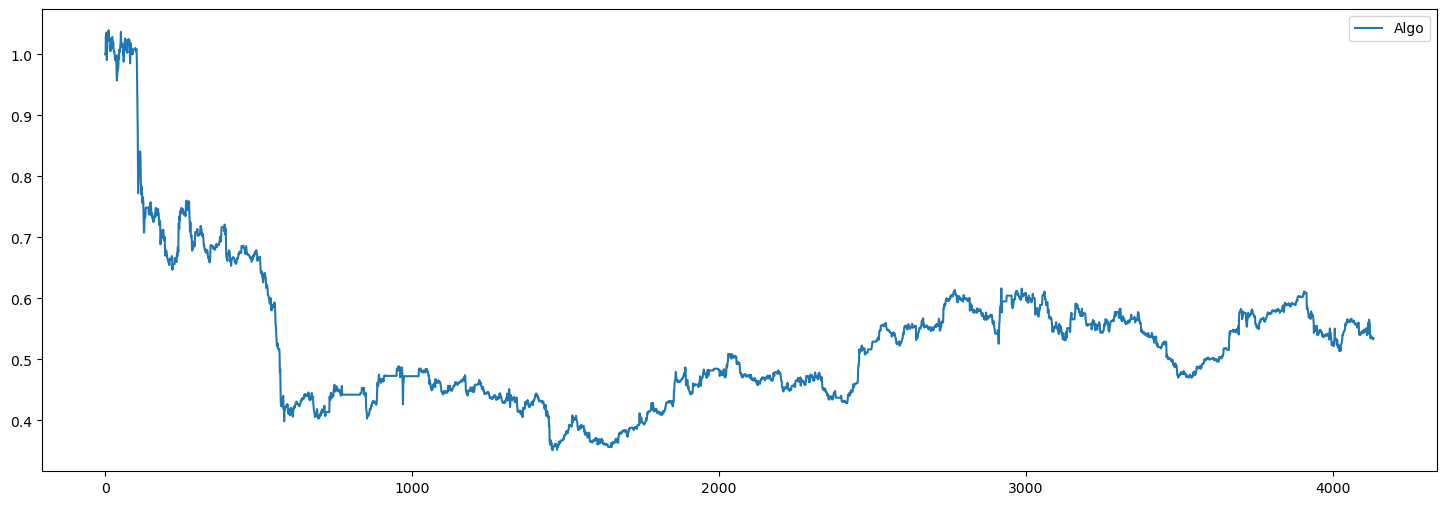

In [243]:
plt.figure(figsize=(18,6))
plt.plot(cumret, label='Algo')
#plt.plot(spy_cumret, label='SPY')
#plt.plot(bbh_cumret, label='BBH')
plt.legend()

## 4h OU

In [172]:
df = pd.read_csv('/Users/imath/Desktop/TMBA/配對交易/pair trade data/df/main_datafram_4h.csv')
df = df.set_index('timestamp')

crypto = ['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ']
etfs = ['BTC']

prices = df[['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ','BTC']]
prices['BTC_'] = prices['BTC']
prices.sort_index()
prices = prices.loc['2021-01-01':'2022-12-01']
prices

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/2029789936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['BTC_'] = prices['BTC']


,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ,BTC,BTC_
timestamp,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0.18292,6.185,350.95,37.9250,0.004978,744.82,11.5006,131.66,0.02716,0.019609,0.13084,159.75,0.22730,2.0724,29278.40,29278.40
2021-01-01 04:00:00+00:00,0.17955,6.026,345.91,37.6812,0.004860,737.38,11.3784,129.41,0.02685,0.019463,0.13193,158.75,0.22976,2.0222,29092.83,29092.83
2021-01-01 08:00:00+00:00,0.17950,6.006,347.97,38.3904,0.004894,738.85,11.7134,127.62,0.02703,0.020021,0.13399,163.93,0.23732,2.0387,29313.49,29313.49
2021-01-01 12:00:00+00:00,0.18055,5.921,344.99,38.1318,0.004918,735.39,12.1183,126.34,0.02704,0.019742,0.13349,167.46,0.24282,2.1015,29188.67,29188.67
2021-01-01 16:00:00+00:00,0.17432,5.801,337.46,37.4000,0.005219,725.34,11.8018,125.26,0.02666,0.018975,0.13274,141.02,0.23371,2.0059,29029.04,29029.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.31500,10.425,112.50,301.0000,0.106220,1272.62,7.4830,78.12,0.05408,0.019050,0.08970,140.30,0.40390,1.0040,16884.18,16884.18
2022-11-30 08:00:00+00:00,0.31470,10.444,112.80,300.5000,0.105060,1266.72,7.4520,78.54,0.05419,0.019070,0.08930,138.80,0.40050,1.0080,16879.32,16879.32
2022-11-30 12:00:00+00:00,0.31520,10.463,112.90,298.0000,0.104180,1267.40,7.4560,77.64,0.05425,0.019040,0.08920,139.80,0.40160,1.0080,16865.64,16865.64


In [173]:
returns = prices.pct_change().dropna()
returns

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ,BTC,BTC_
timestamp,,,,,,,,,,,,,,,,
2021-01-01 04:00:00+00:00,-0.018423,-0.025707,-0.014361,-0.006428,-0.023724,-0.009989,-0.010626,-0.017089,-0.011414,-0.007446,0.008331,-0.006260,0.010823,-0.024223,-0.006338,-0.006338
2021-01-01 08:00:00+00:00,-0.000278,-0.003319,0.005955,0.018821,0.007037,0.001994,0.029442,-0.013832,0.006704,0.028670,0.015614,0.032630,0.032904,0.008159,0.007585,0.007585
2021-01-01 12:00:00+00:00,0.005850,-0.014153,-0.008564,-0.006736,0.004781,-0.004683,0.034567,-0.010030,0.000370,-0.013935,-0.003732,0.021534,0.023175,0.030804,-0.004258,-0.004258
2021-01-01 16:00:00+00:00,-0.034506,-0.020267,-0.021827,-0.019191,0.061351,-0.013666,-0.026118,-0.008548,-0.014053,-0.038851,-0.005618,-0.157888,-0.037518,-0.045491,-0.005469,-0.005469
2021-01-01 20:00:00+00:00,0.004417,0.010343,0.012950,0.010059,0.088269,0.004922,0.003889,0.007824,0.007127,0.004058,-0.005047,-0.036945,0.016046,0.000798,0.010426,0.010426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.007355,0.006371,0.007162,0.017579,0.001603,0.005952,0.010124,-0.003571,0.004271,0.006871,0.006734,0.005014,0.007986,0.004000,0.002311,0.002311
2022-11-30 08:00:00+00:00,-0.000952,0.001823,0.002667,-0.001661,-0.010921,-0.004636,-0.004143,0.005376,0.002034,0.001050,-0.004459,-0.010691,-0.008418,0.003984,-0.000288,-0.000288
2022-11-30 12:00:00+00:00,0.001589,0.001819,0.000887,-0.008319,-0.008376,0.000537,0.000537,-0.011459,0.001107,-0.001573,-0.001120,0.007205,0.002747,0.000000,-0.000810,-0.000810


In [203]:
s_scores = pd.DataFrame(index=returns.index[60:], columns=crypto)
betas = pd.DataFrame(index=returns.index[60:], columns=crypto)

In [204]:
for t in returns.index[60:]:
    # prepare data
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-59:]
    tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
    
    ou_parameters = pd.DataFrame(index=crypto, columns=['a', 'b', 'Var(zeta)', 'kappa', 'm', 
                                                      'sigma', 'sigma_eq'])
    
    for stock in tmp_ret.columns.drop('BTC'):
        X = tmp_ret[['BTC']].values
        y = tmp_ret[stock].values
        model1 = LinearRegression().fit(X,y) 
        betas.loc[t,stock] = model1.coef_
        epsilon = y - model1.predict(X)

        # second regression
        Xk = epsilon.cumsum()
        X = Xk[:-1].reshape(-1,1)
        y = Xk[1:]
        model2 = LinearRegression().fit(X,y)
        a = model2.intercept_
        b = model2.coef_
        zeta = y - model2.predict(X)

        # OU parameters
        kappa = -np.log(b)*252
        m = a/(1-b)
        sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
        sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

        # if the speed of mean reversion is high enough, save the calculated parameters
        if kappa>252/30:
            ou_parameters.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    ou_parameters.dropna(axis=0, inplace=True)

    # calculate s-score
    ou_parameters['m_bar'] = (ou_parameters['a']/(1 - ou_parameters['b']) - 
                              ou_parameters['a'].mean()/(1-ou_parameters['b'].mean()))
    ou_parameters['s'] = -ou_parameters['m_bar'] / ou_parameters['sigma_eq']
    s_scores.loc[t] = ou_parameters['s']

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

In [205]:
s_scores

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 04:00:00+00:00,-0.549765,0.19015,0.440689,-0.479484,NaN,-1.119143,-0.735628,-1.277946,0.193934,-0.878329,-0.361392,2.632524,0.246571,0.154066
2021-01-11 08:00:00+00:00,-0.538853,0.494335,0.545484,-0.454003,NaN,-1.004551,-0.390205,-0.968438,0.499638,-0.812537,-0.257994,1.557141,0.533441,0.527567
2021-01-11 12:00:00+00:00,-0.604694,0.416273,0.457913,-0.688007,NaN,-1.069222,-0.464457,-1.088693,0.591764,-0.958269,-0.266556,1.913034,0.49268,0.282311
2021-01-11 16:00:00+00:00,-0.665682,0.713252,0.241943,-0.616252,NaN,-1.119125,-0.492557,-1.260742,0.533254,-0.860359,-0.297607,1.783625,0.661509,0.200183
2021-01-11 20:00:00+00:00,-0.654424,0.564068,0.396788,-0.655546,-0.344863,-0.980422,-0.429984,-0.933526,0.297704,-0.605482,-0.101122,1.624059,0.533492,0.009498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.115124,0.564839,-1.349044,-0.692687,0.968601,2.367073,-0.476436,-1.405276,-0.328699,0.184938,0.25838,0.627881,0.203771,-0.950935
2022-11-30 08:00:00+00:00,-0.05357,0.568754,-0.821305,-0.765033,0.688402,2.26234,-0.648703,-1.367914,-0.193328,0.25159,0.108558,0.115718,0.014926,0.086167
2022-11-30 12:00:00+00:00,0.350427,0.598113,-0.802363,-0.826343,0.506108,2.426931,-0.816503,-1.08499,-0.272951,-0.082831,0.125254,0.04622,0.068542,1.281917


In [206]:
# calculate positions
algo_pos = pd.DataFrame(index=s_scores.index[1:], columns=crypto)

for s in crypto:
    positions = pd.DataFrame(index=s_scores.index, columns=[s])
    pos = 0
    for t in s_scores.index:
        score = s_scores.loc[t][s]
        if score>1.25:
            positions.loc[t][s] = -1 # open short
            pos = -1
        elif score<-1.25:
            positions.loc[t][s] = 1 # open long
            pos = 1
        elif score< 1  and pos==-1: 
            positions.loc[t][s] = 0 # close short
            pos = 0
        elif score>-1 and pos==1:
            positions.loc[t][s] = 0 # close long
            pos = 0
        else:
            positions.loc[t][s] = pos # carry forward current position

    algo_pos[s] = positions

In [207]:
algo_pos

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 08:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-11 12:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-11 16:00:00+00:00,0,0,0,0,0,0,0,1,0,0,0,-1,0,0
2021-01-11 20:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2021-01-12 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0,0,1,0,0,-1,0,1,0,0,0,0,0,0
2022-11-30 08:00:00+00:00,0,0,0,0,0,-1,0,1,0,0,0,0,0,0
2022-11-30 12:00:00+00:00,0,0,0,0,0,-1,0,1,0,0,0,0,0,-1


In [208]:
# calculate weights (allocate equal amount of capital to long\short positions)
algo_weights = pd.DataFrame(index=algo_pos.index, columns=crypto)

for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) # equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) # equal weights among short positions
    algo_weights.loc[t] = tmp

In [209]:
# calculate returns
ret = (returns.iloc[60:] * algo_weights.shift()).sum(axis=1) / abs(algo_weights.shift().replace(np.nan, 0)).sum(axis=1)/2
cumret = np.nancumprod(ret+1)


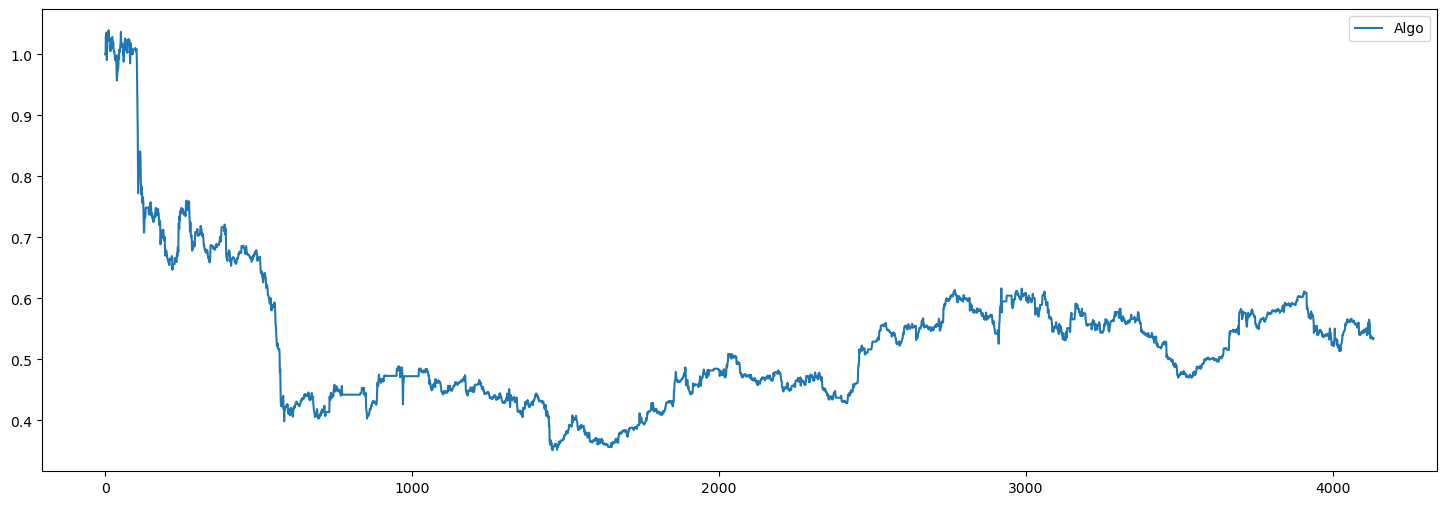

In [210]:
plt.figure(figsize=(18,6))
plt.plot(cumret, label='Algo')
#plt.plot(spy_cumret, label='SPY')
#plt.plot(bbh_cumret, label='BBH')
plt.legend()

## 2h OU

In [182]:
df = pd.read_csv('/Users/imath/Desktop/TMBA/配對交易/pair trade data/df/main_dataframe_2h.csv')
df = df.set_index('timestamp')

crypto = ['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ']
etfs = ['BTC']

prices = df[['ADA', 'ATOM','BCH','BNB','DOGE','ETH','LINK','LTC','TRX','VET','XLM','XMR','XRP','XTZ','BTC']]
prices['BTC_'] = prices['BTC']
prices.sort_index()
prices = prices.loc['2021-01-01':'2022-12-01']
prices

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/326119172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['BTC_'] = prices['BTC']


,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ,BTC,BTC_
timestamp,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0.18358,6.318,349.71,37.6134,0.004737,748.28,11.4735,131.70,0.02719,0.019805,0.13304,160.01,0.22382,2.0605,29409.99,29409.99
2021-01-01 02:00:00+00:00,0.18292,6.185,350.95,37.9250,0.004978,744.82,11.5006,131.66,0.02716,0.019609,0.13084,159.75,0.22730,2.0724,29278.40,29278.40
2021-01-01 04:00:00+00:00,0.18297,6.065,348.18,37.7129,0.004942,740.65,11.4431,130.88,0.02702,0.019664,0.13344,160.04,0.23819,2.0371,29187.01,29187.01
2021-01-01 06:00:00+00:00,0.17955,6.026,345.91,37.6812,0.004860,737.38,11.3784,129.41,0.02685,0.019463,0.13193,158.75,0.22976,2.0222,29092.83,29092.83
2021-01-01 08:00:00+00:00,0.17904,5.995,344.11,37.9477,0.004815,733.68,11.3505,127.32,0.02685,0.019398,0.13175,161.63,0.23259,2.0170,29202.21,29202.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 14:00:00+00:00,0.31520,10.463,112.90,298.0000,0.104180,1267.40,7.4560,77.64,0.05425,0.019040,0.08920,139.80,0.40160,1.0080,16865.64,16865.64
2022-11-30 16:00:00+00:00,0.31100,10.286,111.10,295.5000,0.101590,1266.10,7.3380,77.22,0.05380,0.019010,0.08800,140.40,0.39570,0.9910,16789.66,16789.66
2022-11-30 18:00:00+00:00,0.31440,10.441,112.90,298.4000,0.103880,1287.20,7.4690,78.11,0.05434,0.019210,0.08920,141.30,0.40750,1.0130,17062.85,17062.85


In [190]:
s_scores = pd.DataFrame(index=returns.index[120:], columns=crypto)
betas = pd.DataFrame(index=returns.index[120:], columns=crypto)

In [197]:
for t in returns.index[120:]:
    # prepare data
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-119:]
    tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
    
    ou_parameters = pd.DataFrame(index=crypto, columns=['a', 'b', 'Var(zeta)', 'kappa', 'm', 
                                                      'sigma', 'sigma_eq'])
    
    for stock in tmp_ret.columns.drop('BTC'):
        X = tmp_ret[['BTC']].values
        y = tmp_ret[stock].values
        model1 = LinearRegression().fit(X,y) 
        betas.loc[t,stock] = model1.coef_
        epsilon = y - model1.predict(X)

        # second regression
        Xk = epsilon.cumsum()
        X = Xk[:-1].reshape(-1,1)
        y = Xk[1:]
        model2 = LinearRegression().fit(X,y)
        a = model2.intercept_
        b = model2.coef_
        zeta = y - model2.predict(X)

        # OU parameters
        kappa = -np.log(b)*252
        m = a/(1-b)
        sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
        sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

        # if the speed of mean reversion is high enough, save the calculated parameters
        if kappa>252/30:
            ou_parameters.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    ou_parameters.dropna(axis=0, inplace=True)

    # calculate s-score
    ou_parameters['m_bar'] = (ou_parameters['a']/(1 - ou_parameters['b']) - 
                              ou_parameters['a'].mean()/(1-ou_parameters['b'].mean()))
    ou_parameters['s'] = -ou_parameters['m_bar'] / ou_parameters['sigma_eq']
    s_scores.loc[t] = ou_parameters['s']

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:27: RuntimeWarning: divide by zero encountered in log
  kappa = -np.log(b)*252
/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1523077780.py:29: RuntimeWarning: invalid value encountered in multiply
  sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))


In [198]:
s_scores

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 04:00:00+00:00,-0.549765,0.19015,0.440689,-0.479484,NaN,-1.119143,-0.735628,-1.277946,0.193934,-0.878329,-0.361392,2.632524,0.246571,0.154066
2021-01-11 08:00:00+00:00,-0.538853,0.494335,0.545484,-0.454003,NaN,-1.004551,-0.390205,-0.968438,0.499638,-0.812537,-0.257994,1.557141,0.533441,0.527567
2021-01-11 12:00:00+00:00,-0.604694,0.416273,0.457913,-0.688007,NaN,-1.069222,-0.464457,-1.088693,0.591764,-0.958269,-0.266556,1.913034,0.49268,0.282311
2021-01-11 16:00:00+00:00,-0.665682,0.713252,0.241943,-0.616252,NaN,-1.119125,-0.492557,-1.260742,0.533254,-0.860359,-0.297607,1.783625,0.661509,0.200183
2021-01-11 20:00:00+00:00,-0.654424,0.564068,0.396788,-0.655546,-0.344863,-0.980422,-0.429984,-0.933526,0.297704,-0.605482,-0.101122,1.624059,0.533492,0.009498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.788536,NaN,-0.94269,NaN,0.813007,0.42247,1.125874,-0.433542,NaN,0.87127,-0.330851,-0.522557,-0.163899,0.853512
2022-11-30 08:00:00+00:00,0.523503,1.384658,-1.236612,NaN,0.64844,0.561233,1.03004,-0.502121,NaN,0.754163,0.309695,-0.772573,-0.357111,0.829678
2022-11-30 12:00:00+00:00,0.579161,NaN,-1.100821,NaN,0.534835,0.367176,1.005991,-0.53165,NaN,0.780443,0.026676,-0.489019,-0.176063,0.956012


In [199]:
# calculate positions
algo_pos = pd.DataFrame(index=s_scores.index[1:], columns=crypto)

for s in crypto:
    positions = pd.DataFrame(index=s_scores.index, columns=[s])
    pos = 0
    for t in s_scores.index:
        score = s_scores.loc[t][s]
        if score>1.25:
            positions.loc[t][s] = -1 # open short
            pos = -1
        elif score<-1.25:
            positions.loc[t][s] = 1 # open long
            pos = 1
        elif score< 1  and pos== -1: 
            positions.loc[t][s] = 0 # close short
            pos = 0
        elif score>-1 and pos== 1:
            positions.loc[t][s] = 0 # close long
            pos = 0
        else:
            positions.loc[t][s] = pos # carry forward current position

    algo_pos[s] = positions
    

In [200]:
# calculate weights (allocate equal amount of capital to long\short positions)
algo_weights = pd.DataFrame(index=algo_pos.index, columns=crypto)

for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) # equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) # equal weights among short positions
    algo_weights.loc[t] = tmp

In [201]:
# calculate returns
ret = (returns.iloc[30:] * algo_weights.shift()).sum(axis=1) / abs(algo_weights.shift().replace(np.nan, 0)).sum(axis=1)/2
cumret = np.nancumprod(ret+1)


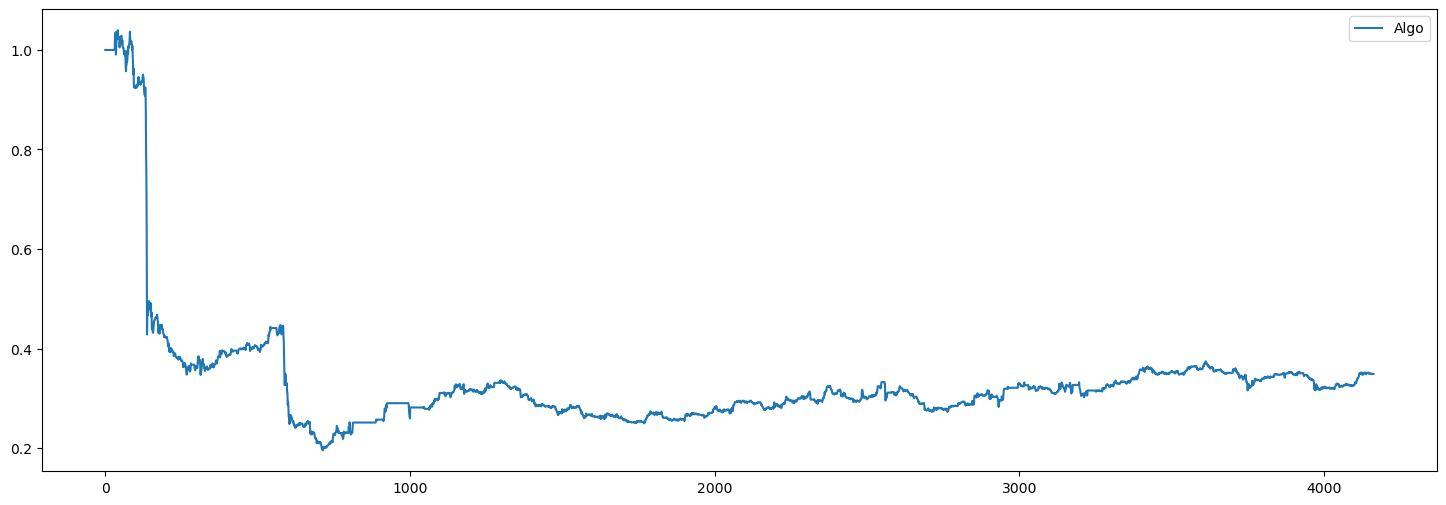

In [202]:
plt.figure(figsize=(18,6))
plt.plot(cumret, label='Algo')
#plt.plot(spy_cumret, label='SPY')
#plt.plot(bbh_cumret, label='BBH')
plt.legend()

## 1h OU

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [70]:
df = pd.read_csv('/Users/imath/Desktop/TMBA/配對交易/pair trade data/df/main_datafram_1h.csv')
df = df.set_index('timestamp')

crypto = [ 'AAVE', 'ADA', 'ALGO',  'ATOM', 'AVAX', 'AXS', 'BCH',
       'BNB', 'DOGE', 'DOT', 'EGLD', 'EOS', 'ETC', 'ETH', 'FIL',
        'HBAR', 'ICP', 'LINK', 'LTC', 'MATIC', 'NEAR', 'SOL', 'THETA', 'TRX', 'UNI', 'VET',
       'XLM', 'XMR', 'XRP', 'XTZ']
etfs = ['BTC']

In [71]:
prices = df[[ 'AAVE', 'ADA', 'ALGO',  'ATOM', 'AVAX', 'AXS', 'BCH',
       'BNB', 'DOGE', 'DOT', 'EGLD', 'EOS', 'ETC', 'ETH', 'FIL',
        'HBAR', 'ICP', 'LINK', 'LTC', 'MATIC', 'NEAR', 'SOL', 'THETA', 'TRX', 'UNI', 'VET',
       'XLM', 'XMR', 'XRP', 'XTZ','BTC']]
prices.sort_index()
prices = prices.loc['2021-01-01':'2022-12-01']
prices

,AAVE,ADA,ALGO,ATOM,AVAX,AXS,BCH,BNB,DOGE,DOT,...,SOL,THETA,TRX,UNI,VET,XLM,XMR,XRP,XTZ,BTC
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,88.097,0.18051,0.3460,6.401,3.2461,0.53441,341.44,37.3764,0.004679,9.2609,...,1.5442,1.86184,0.02680,5.2241,0.019238,0.12879,156.92,0.22162,2.0038,28995.13
2021-01-01 01:00:00+00:00,87.422,0.18358,0.3447,6.318,3.1709,0.53366,349.71,37.6134,0.004737,9.2432,...,1.5734,1.84953,0.02719,5.1663,0.019805,0.13304,160.01,0.22382,2.0605,29409.99
2021-01-01 02:00:00+00:00,87.882,0.18368,0.3542,6.378,3.0891,0.53321,354.37,37.9600,0.004755,9.0809,...,1.5872,1.91200,0.02728,5.1846,0.019792,0.13272,161.32,0.22361,2.0828,29194.65
2021-01-01 03:00:00+00:00,88.454,0.18292,0.3591,6.185,3.1085,0.54173,350.95,37.9250,0.004978,9.1177,...,1.6029,1.97013,0.02716,5.1548,0.019609,0.13084,159.75,0.22730,2.0724,29278.40
2021-01-01 04:00:00+00:00,87.431,0.18180,0.3525,6.087,3.0901,0.53912,348.21,37.8702,0.004894,9.0600,...,1.6022,1.93700,0.02705,5.1118,0.019718,0.13340,159.88,0.23898,2.0358,29220.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 19:00:00+00:00,65.100,0.31440,0.2438,10.441,12.9300,6.91000,112.90,298.4000,0.103880,5.4100,...,13.6400,0.95000,0.05434,5.8200,0.019210,0.08920,141.30,0.40750,1.0130,17062.85
2022-11-30 20:00:00+00:00,65.900,0.31670,0.2463,10.464,12.9900,6.95000,113.50,300.6000,0.104370,5.4500,...,13.7300,0.95500,0.05451,5.8600,0.019300,0.08970,141.30,0.40950,1.0130,17097.19
2022-11-30 21:00:00+00:00,65.700,0.32080,0.2480,10.500,13.0600,6.99000,113.30,300.7000,0.106000,5.4700,...,13.8700,0.95600,0.05459,5.8500,0.019250,0.08990,142.10,0.41030,1.0170,17106.65


In [72]:
s_scores = pd.DataFrame(index=returns.index[60:], columns=crypto)
betas = pd.DataFrame(index=returns.index[60:], columns=crypto)

In [73]:
for t in returns.index[60:]:
    # prepare data
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-59:]
    tmp_ret = (tmp_ret - tmp_ret.mean()) / tmp_ret.std()
    
    ou_parameters = pd.DataFrame(index=crypto, columns=['a', 'b', 'Var(zeta)', 'kappa', 'm', 
                                                      'sigma', 'sigma_eq'])
    
    for stock in tmp_ret.columns.drop('BTC'):
        X = tmp_ret[['BTC']].values
        y = tmp_ret[stock].values
        model1 = LinearRegression().fit(X,y) 
        betas.loc[t,stock] = model1.coef_
        epsilon = y - model1.predict(X)

        # second regression
        Xk = epsilon.cumsum()
        X = Xk[:-1].reshape(-1,1)
        y = Xk[1:]
        model2 = LinearRegression().fit(X,y)
        a = model2.intercept_
        b = model2.coef_
        zeta = y - model2.predict(X)

        # OU parameters
        kappa = -np.log(b)*252
        m = a/(1-b)
        sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
        sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

        # if the speed of mean reversion is high enough, save the calculated parameters
        if kappa>252/30:
            ou_parameters.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    ou_parameters.dropna(axis=0, inplace=True)

    # calculate s-score
    ou_parameters['m_bar'] = (ou_parameters['a']/(1 - ou_parameters['b']) - 
                              ou_parameters['a'].mean()/(1-ou_parameters['b'].mean()))
    ou_parameters['s'] = -ou_parameters['m_bar'] / ou_parameters['sigma_eq']
    s_scores.loc[t] = ou_parameters['s']

/var/folders/2_/vqqcrgw52112241mx3hdsxsc0000gn/T/ipykernel_60683/1684449667.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))


In [74]:
s_scores

,AAVE,ADA,ALGO,ATOM,AVAX,AXS,BCH,BNB,DOGE,DOT,...,NEAR,SOL,THETA,TRX,UNI,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-05-21 04:00:00+00:00,-1.118373,-0.517104,-0.179538,-0.511281,-0.892447,0.090773,-0.435396,-0.09921,-0.075535,-0.965946,...,-1.209581,0.274662,-0.178144,-0.235671,-1.088453,0.455507,-0.546619,0.71981,-0.397971,-0.483838
2021-05-21 08:00:00+00:00,-1.268021,-0.678797,-0.243259,-0.567835,-0.924137,0.222553,-0.107686,-0.185136,0.000565,-0.985833,...,-1.177135,-0.009731,-0.137415,0.001671,-1.147048,0.23254,-0.265038,0.986246,-0.357679,-0.148036
2021-05-21 12:00:00+00:00,-1.334179,-0.649451,-0.17015,-0.448329,-0.668469,0.187177,0.251891,-0.252702,-0.029995,-1.035493,...,-1.10974,-0.022699,-0.123189,0.141497,-1.196494,0.470404,0.0024,1.048287,-0.282219,0.057512
2021-05-21 16:00:00+00:00,-1.149636,-0.775972,-0.340653,-0.628663,-0.695707,0.235307,0.331679,-0.411498,-0.214071,-0.960503,...,-1.247845,0.256096,-0.128427,0.226192,-0.631542,0.356868,-0.486489,0.940736,-0.292497,0.004177
2021-05-21 20:00:00+00:00,-1.090673,-0.867732,-0.359031,-0.643245,-0.618934,0.709632,0.173522,-0.492124,-0.22082,-0.920212,...,-1.100971,0.019384,-0.050519,-0.099884,-0.531059,0.121393,-0.79753,0.723639,-0.489483,0.112672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0.533776,-0.360413,1.723252,0.223423,-0.373202,0.694912,-1.53001,-0.826182,0.784477,1.044868,...,0.696247,-0.958173,-0.131692,-0.614249,1.882053,-0.144791,-0.070122,0.201432,-0.001542,-1.634251
2022-11-30 08:00:00+00:00,0.875375,-0.575186,1.018337,0.187678,-0.437759,1.173644,-0.97612,-0.909464,0.497441,0.769115,...,1.170043,-1.001704,-0.110537,-0.50091,0.895269,-0.111528,-0.216553,-0.279067,-0.196538,-0.628542
2022-11-30 12:00:00+00:00,1.46277,-0.150979,1.274462,0.201531,-1.024102,0.842353,-0.98207,-0.957681,0.319307,1.20802,...,0.783401,-1.069273,-0.08308,-0.56388,1.502751,-0.47448,-0.19651,-0.393164,-0.142182,0.788474


In [75]:
# calculate positions
algo_pos = pd.DataFrame(index=s_scores.index[1:], columns=crypto)

for s in crypto:
    positions = pd.DataFrame(index=s_scores.index, columns=[s])
    pos = 0
    for t in s_scores.index:
        score = s_scores.loc[t][s]
        if score>1.25:
            positions.loc[t][s] = -1 # open short
            pos = -1
        elif score<-1.25:
            positions.loc[t][s] = 1 # open long
            pos = 1
        elif score < 1  and pos==-1: 
            positions.loc[t][s] = 0 # close short
            pos = 0
        elif score>-1 and pos==1:
            positions.loc[t][s] = 0 # close long
            pos = 0
        else:
            positions.loc[t][s] = pos # carry forward current position

    algo_pos[s] = positions

In [76]:
# calculate weights (allocate equal amount of capital to long\short positions)
algo_weights = pd.DataFrame(index=algo_pos.index, columns=crypto)

for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) # equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) # equal weights among short positions
    algo_weights.loc[t] = tmp

In [134]:
algo_weights

,ADA,ATOM,BCH,BNB,DOGE,ETH,LINK,LTC,TRX,VET,XLM,XMR,XRP,XTZ
timestamp,,,,,,,,,,,,,,
2021-01-11 08:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1.0,0,0
2021-01-11 12:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1.0,0,0
2021-01-11 16:00:00+00:00,0,0,0,0,0,0,0,-0.5,0,0,0,-0.5,0,0
2021-01-11 20:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1.0,0,0
2021-01-12 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 04:00:00+00:00,0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,0,0,0
2022-11-30 08:00:00+00:00,0,-0.111111,0,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,0,0,0
2022-11-30 12:00:00+00:00,0,-0.111111,0,-0.111111,-0.111111,-0.111111,-0.111111,0,-0.111111,-0.111111,-0.111111,0,0,-0.111111


In [77]:
# calculate returns
ret = (returns.iloc[60:] * algo_weights.shift()).sum(axis=1) / abs(algo_weights.shift().replace(np.nan, 0)).sum(axis=1)/2
cumret = np.nancumprod(ret+1)


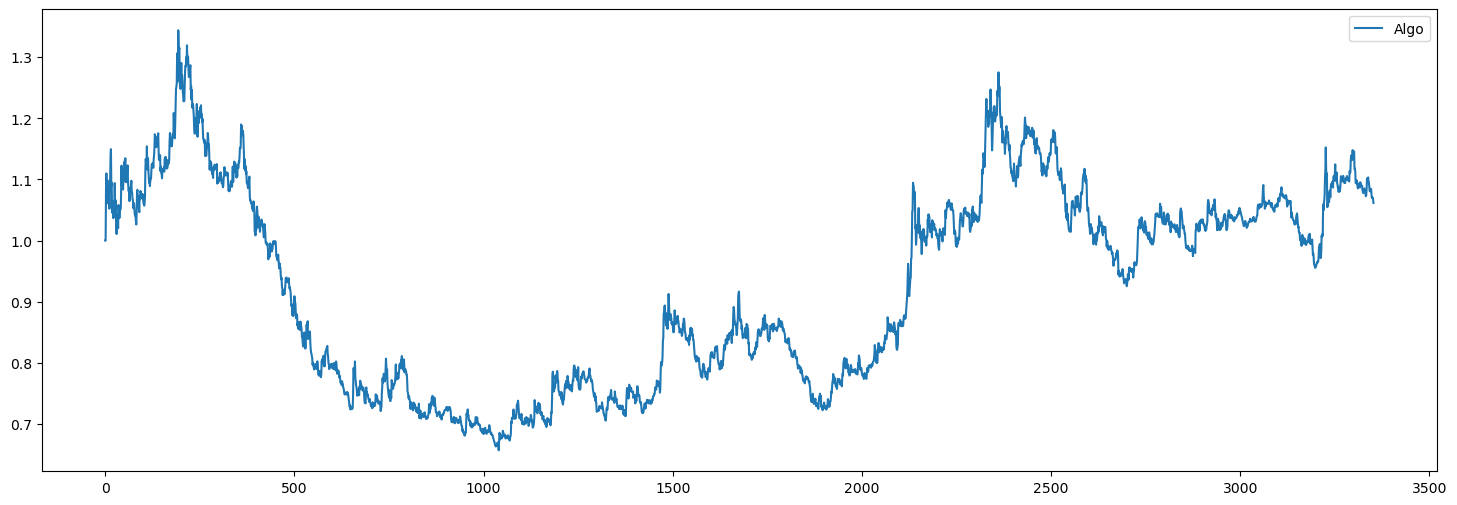

In [78]:
plt.figure(figsize=(18,6))
plt.plot(cumret, label='Algo')
#plt.plot(spy_cumret, label='SPY')
#plt.plot(bbh_cumret, label='BBH')
plt.legend()